In [1]:
#all imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
rcParams['figure.figsize']=20,10

In [2]:
#read the dataset
#A Pandas DataFrame is a 2 dimensional data structure, like a 2 dimensional array, or a table with rows and columns.
#load data into a DataFrame object df:
df=pd.read_csv("NSE-TATA.csv")
#default shows first five rows
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


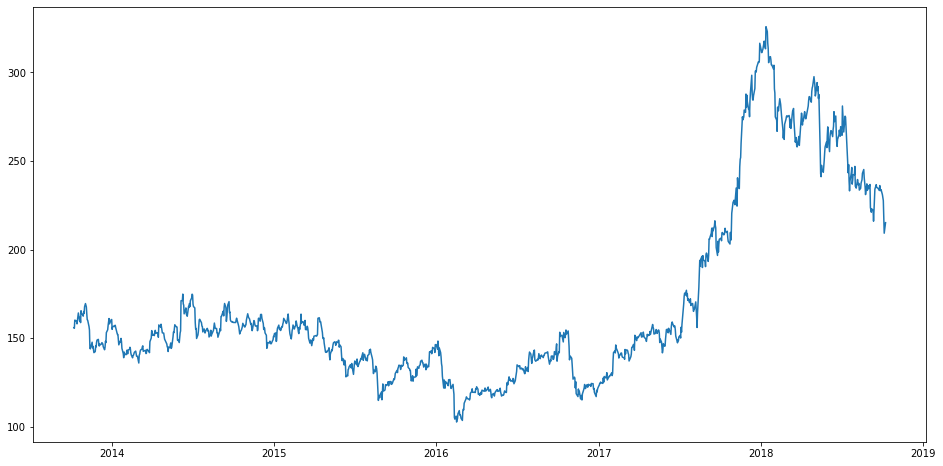

In [15]:
#analyze the closing prices from dataframe
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
#With the index argument, you can name your own indexes.
df.index=df['Date']

#The figure() function in pyplot module of matplotlib library is used to create a new figure.
#figsize(float, float): These parameter are the width, height in inches.
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [20]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
clos=df["Close"]
clos.head()

Date
2018-10-08    215.15
2018-10-05    209.20
2018-10-04    218.20
2018-10-03    227.60
2018-10-01    230.90
Name: Close, dtype: float64

In [5]:
#Sort the dataset on date time and filter “Date” and “Close” columns:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [6]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values
#the following are lists which considers from index 0 to 987, 3rd : used no of index to move forward
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

In [8]:
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

#creating data with timesteps
#LSTMs expect our data to be in a specific format, usually a 3D array.
#start by creating data in 60 timesteps,& converting it into an array using NumPy.
#Next, we convert the data into a 3D dimension array with X_train samples, 60 timestamps, and one feature at each step.
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [9]:
#Build and train the LSTM model:
#We add the LSTM layer with the following arguments:
#50 units which is the dimensionality of the output space
#return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence
#input_shape as the shape of our training set.
#add the Dense layer that specifies the output of 1 unit.
#compile our model using the popular adam optimizer and set the loss as the mean_squarred_error, to compute mean of squared errors.
#fit the model to run on 1 epochs with a batch size of 1
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))




lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

#In order to predict future stock prices we need to do a couple of things after loading in the test set:
#Merge the training set and the test set on the 0 axis.
#Set the time step as 60 (as seen previously)
#Use MinMaxScaler to transform the new dataset
#Reshape the dataset as done previously
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

927/927 - 31s - loss: 0.0012


In [11]:
#Take a sample of a dataset to make stock price predictions using the LSTM model:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# make predictions
closing_price=lstm_model.predict(X_test)
# invert predictions
#After making the predictions we use inverse_transform to get back the stock prices in normal readable format.
closing_price=scaler.inverse_transform(closing_price)

In [12]:
#Save the LSTM model:
lstm_model.save("saved_lstm_model.h5")

<ipython-input-14-eb292387a2e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


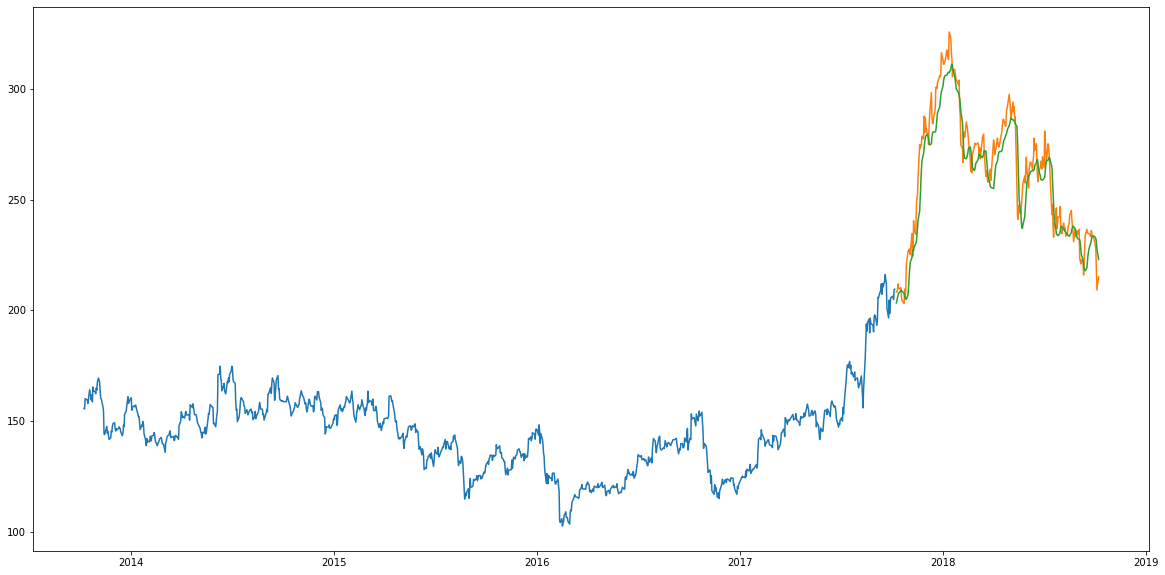

In [14]:
#Visualize the predicted stock costs with actual stock costs:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
#Once prepared, the data is plotted, showing the original dataset in blue, 
#the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.